In [1]:
LR = 0.005
EPOCHS = 2
BATCHSIZE = 32
CHANNELS = 64
IMAGE_SIZE = 512
NBLOCK = 6 
DEPTH = 2
MOMENTUM = 0.9


from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics
from tensorflow import keras


from keras.applications.vgg16  import VGG16
from keras.layers.core import Dense, Dropout, Flatten



D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)


In [3]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_random_seed(10)


In [4]:
import os
os.chdir(r"E:\rsna_n\rsna-pneumonia-detection-challenge")

In [5]:
directory = 'RSNA_NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory))) 
labels_norm = ['0'] * len(image_paths_norm)


In [6]:
directory = 'RSNA_LUNGOPACITY/'
image_paths_pn = sorted(list(paths.list_images(directory))) 

labels_pn = ['1'] * len(image_paths_pn)

image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

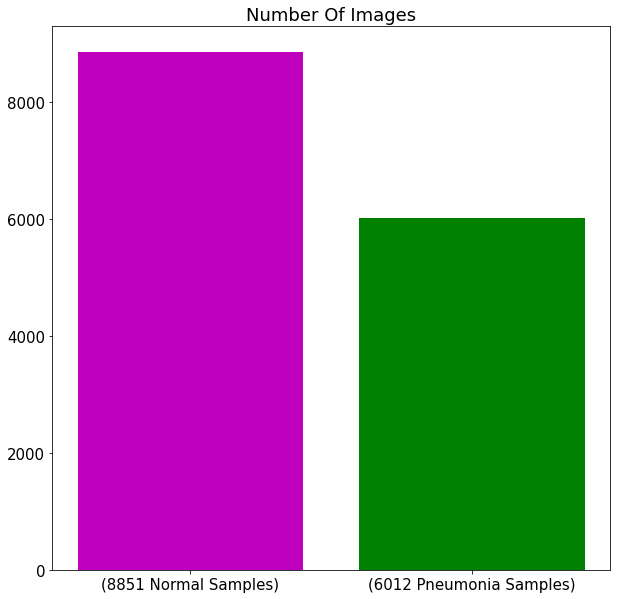

In [7]:
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Images'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]



In [9]:
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])


In [10]:
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(224, 224),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE,
                                        class_mode='raw',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(224, 224),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE,
                                        class_mode='raw',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(224, 224),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE,
                                        class_mode='raw',
                                        shuffle=False)


Found 10404 validated image filenames.
Found 2229 validated image filenames.
Found 2230 validated image filenames.


In [11]:
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 224, 224, 1], [None, ]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 224, 224, 1], [None, ]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 224, 224, 1], [None, ]))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [12]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))


In [13]:
def feed_data(dataset):

    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset


In [14]:
from keras.layers import Input
from keras.applications.vgg16  import VGG16
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Model

input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_input, input_shape=input_shape)
x = base_model.output
print(base_model.output_shape[1:])
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len([0,1])-1, activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)


(7, 7, 512)


In [15]:
from keras.optimizers import SGD
    
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy', 'binary_accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras.callbacks as kcall
weight_path="{}_weights.best.hdf5".format('vgg16RSNAl')
weight_path
class LossHistory(kcall.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []
        self.batch_acc = []
        self.epochs_losses = []
        self.epochs_acc = []
        self.epochs_val_losses = []
        self.epochs_val_acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))
        self.batch_acc.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.epochs_losses.append(logs.get('loss'))
        self.epochs_acc.append(logs.get('acc'))
        self.epochs_val_losses.append(logs.get('val_loss'))
        self.epochs_val_acc.append(logs.get('val_acc'))
history = LossHistory()

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

callbacks_list = [checkpoint, early, history]
callbacks_list
from keras.optimizers import SGD
    
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [17]:
history = model.fit_generator(generator = train_gen,                    
                    epochs=20,                    
                    steps_per_epoch=train_gen.n//train_gen.batch_size,                    
                    validation_data=val_gen,
                    validation_steps=val_gen.n//val_gen.batch_size,                    
                    shuffle=False,
                    callbacks = callbacks_list)



Epoch 1/20
650/650 [==============================] - 221s 339ms/step - loss: 0.3139 - accuracy: 0.8670 - precision: 0.7830 - recall: 0.7323 - val_loss: 0.3441 - val_accuracy: 0.8669 - val_precision: 0.8635 - val_recall: 0.7988

Epoch 00001: val_loss improved from inf to 0.34407, saving model to vgg16RSNAl_weights.best.hdf5
Epoch 2/20
650/650 [==============================] - 224s 344ms/step - loss: 0.2320 - accuracy: 0.9126 - precision: 0.8829 - recall: 0.8104 - val_loss: 0.2393 - val_accuracy: 0.9277 - val_precision: 0.8917 - val_recall: 0.8300

Epoch 00002: val_loss improved from 0.34407 to 0.23931, saving model to vgg16RSNAl_weights.best.hdf5
Epoch 3/20
650/650 [==============================] - 228s 351ms/step - loss: 0.2106 - accuracy: 0.9237 - precision: 0.8968 - recall: 0.8426 - val_loss: 0.0371 - val_accuracy: 0.9232 - val_precision: 0.9031 - val_recall: 0.8487

Epoch 00003: val_loss improved from 0.23931 to 0.03705, saving model to vgg16RSNAl_weights.best.hdf5
Epoch 4/20
65

In [18]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

#lr_scheduler = LearningRateScheduler(lr_decay, 1)
csv_logger = CSVLogger(filename='RSNA_VGG16.csv')
model_checkpoint = ModelCheckpoint(filepath='RSNA_VGG16{epoch:04d}.hdf5')


In [19]:
import pandas as pd
seven_layer_aug = pd.read_csv("RSNA_VGG16.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'RSNA_VGG16.csv'

In [ ]:
def plot_loss(results, title, ylim=None, figsize=(15, 15)):

    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_loss'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['loss'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.ylim(ylim)
    plt.grid(lw=2, ls='--')


In [ ]:
def plot_accuracy(results, title, x_range=20, figsize=(15, 15)):

    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_accuracy'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['accuracy'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(lw=2, ls='--')


In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()